

# **RAPPORT DU PROJET DE MACHINE LEARNING**

### Prédiction de victoire de match du jeu League of Legends

*BREGIER Mathéo -
GARRY Arnaud -
KAING Stacy -
TROGNON Jean-Baptiste*


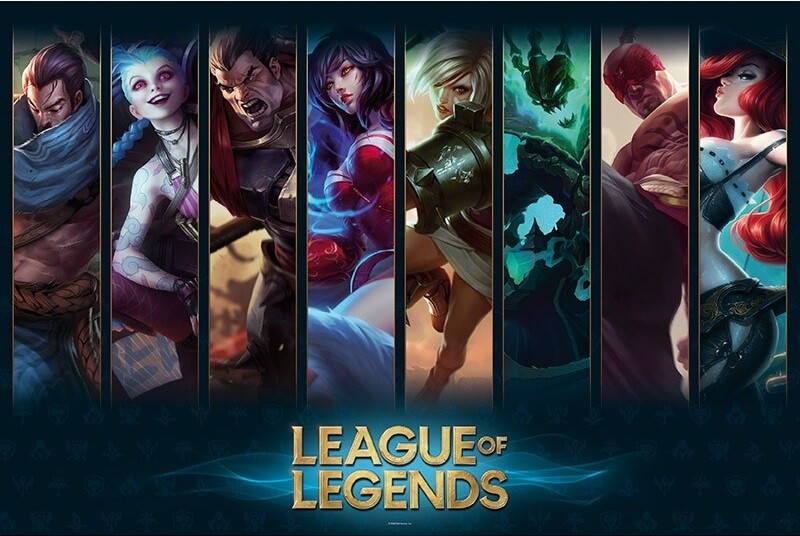


### **SOMMAIRE**
1.   Introduction

2.   Sélection du dataset

3. Définition du problème
4. Méthodologie
5. Paufinement des modèles
6. Résultats obtenus et discussions
7. Solution Finale
8. Annexes





# **1. INTRODUCTION**

  League of Legends (abrégé LoL) est un jeu en ligne multijoueur de type MOBA (arène de bataille en ligne multijoueur) sorti en 2009 développé par Riot Games.  Il possède une des communautés de jeu les plus importantes au monde avec près de 180 millions de joueurs actifs chaque mois en 2023.


Deux équipes, rouge et bleue, de chacune cinq joueurs s’affrontent sur une carte afin de détruire le Nexus, bâtiment principal de l’équipe adverse protégée par des tourelles. Chaque partie commence par une phase de sélection dans laquelle les deux équipes sélectionnent et bannissent cinq champions chacune dans un ordre spécifique. Il y a cinq positions parmi lesquelles chaque joueur peut choisir, et chaque joueur sélectionne un champion qui convient le mieux à sa position et au rôle qui y est lié. Ces rôles sont :


> -	Top lane, joué sur la voie supérieure de la carte
-	Mid lane, joué sur la voie du milieu
-	Bot lane, joué sur la voie inférieure
-	Support, qui est initialement joué sur la voie inférieure, mais qui devient plus tard un rôle de soutien pour toute l'équipe
-	Jungler, joué dans la zone de la jungle, qui existe entre les voies

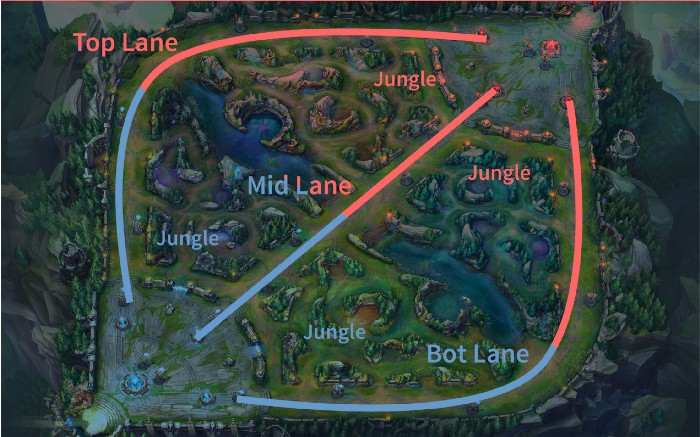


Il y a au total 162 champions, chacun ayant ses propres compétences et classés en plusieurs catégories : les tireurs, les mages, les tanks, les assassins, les combattants, etc. 
Ainsi, une des choses les plus importante dans le jeu est la composition de l’équipe.


Etant des joueurs, nous souhaitons répondre à la question : "*Est-il possible de prédire le résultat d'un match en ne connaissant que la composition des deux équipes ?*"

# **2. SELECTION DU DATASET**

### 2.1 Constitution du dataset

Notre dataset intitulé "*League of Legends Team Compositions Datase*" provient de Kaggle et est disponible via ce lien :
https://www.kaggle.com/datasets/luisfmcuriel/league-of-legends-team-compositions-dataset?select=Champs

Il est constitué de 3 fichiers. Pour notre projet, nous avons conservé le fichier principal "Lol_matchs.csv" contenant un tableau 34678 x 302, les deux autres étant seulement des fichiers contenant les mêmes informations mais séparées (*Champs et Results*).


Chaque ligne correspond à un match avec une première colonne correspondant à son ID. 
Le dataset prend en compte 150 personnages. Les 300 premières colonnes correspondent aux champions choisis par chaque équipe (150x2): 1 si le champion est joué, 0 sinon. 

Les deux dernières colonnes donnent le résultat du match (une colonne pour chaque équipe): 1 dans la première colonne si l'équipe 1 a gagné, 0 si elle a perdu et de même pour l'équipe 2. Il n'est pas possible d'avoir 1 dans les deux colonnes pour une ligne.


### 2.2 Nettoyage du dataset

L'encodage one-hot est une technique de prétraitement de données qui permet de transformer des variables catégorielles en vecteurs binaires représentant la présence ou l'absence de chaque catégorie. Cette technique est utilisée pour représenter des variables catégorielles sous forme numérique afin de les utiliser comme entrée pour les algorithmes de Machine Learning.


Les données de notre dataset ayant été déjà one-hot encodées, nous avons conservé la forme du dataset en retirant la colonne contenant le résultat du match pour l'équipe 2. Nous avons considéré que cette donnée étant redondante, et que le résultat du match pour l'équipe 1 était suffisante.

In [1]:
# INFORMATION POUR LE CODE ---------------------------- #
# L'entraînement de nos modèles et la procédure de cross-validation sur ceux-ci ne prend normalement pas plus de 5min.
# Le code peut donc être exécuté en même temps que la lecture.

In [2]:
import pandas as pd

dataset = pd.read_csv('Lol_matchs.csv')
dataset = dataset.drop(columns="Unnamed: 0")  # On retire la première colonne qui est un ancien index
dataset = dataset.drop(columns="Team2")       # On retire la colonne "Team2" qui ne donne pas d'information supplémentaire

dataset.head()

,Aatrox,Ahri,Akali,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,...,Yone.1,Yorick.1,Yuumi.1,Zac.1,Zed.1,Ziggs.1,Zilean.1,Zoe.1,Zyra.1,Team1
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# **3. DEFINITION DU PROBLEME**

Le problème peut être défini comme un problème de classification supervisé en Apprentissage Automatique. 
L'objectif est de prédire si une équipe va gagner en utilisant comme entrée les champions joués dans chaque équipe et le résultat du match

> - En entrée : Compositions des 2 équipes (5 champions) de 34 678 matchs
- En sortie : {Victoire de l'équipe 1, Défaite de l'équipe 1}

Différentes caractéristiques peuvent être considérées pour ce modèle:
- Les champions joués
- Les synergies entre les champions
- Les statistiques de chaque joueur
- Le classement ELO
- Le résultat des matchs précédents
...

En premier temps, nous avons considéré comme caractéristiques uniquement les champions joués.



# **4. METHODOLOGIE**

Afin de traiter le problème ainsi défini, nous allons utiliser trois modèles différents comme méthode de prédiction :

- Decision Tree Classifier (DT)
- Random Forest Classifier (RF)
- Artificial Neural Network (ANN)

## 4.1 Répartition des données

Le dataset a été divisé en deux catégories distinctes : les données d'entraînement et les données de test.



Les données d'entraînement représentent 2/3 de l'ensemble du dataset, tandis que les données de test représentent 1/3 de l'ensemble du dataset. 

Cette division permet de s'assurer que le modèle est capable de généraliser correctement à de nouveaux exemples, en évitant le surapprentissage et en évaluant sa performance sur des données qui n'ont pas été utilisées lors de l'entraînement.

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

input_dataframe = dataset.drop(columns="Team1")  # On récupère toutes les colonnes sauf la colonne des victoires
output_dataframe = dataset[["Team1"]]            # On récupère seulement la colonne des victoires

# On converti les dataframe en numpy array
X = input_dataframe.to_numpy()
Y = output_dataframe.to_numpy().ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # On divise notre jeu de données
print(X_train.shape)
print(X_test.shape)

(23234, 300)
(11444, 300)


## 4.2 Modèle Decision Tree (DT)

Le premier modèle que nous utilisons est celui de Decision Tree. Pour cela, on utilise la bibliothèque Scikit-learn.

In [4]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=150, max_features=300)
dt_clf = dt_clf.fit(X_train, y_train)

dt_accuracy = dt_clf.score(X_test, y_test) # la fonction score() pour un DecisionTreeClassifier renvoie l'accuracy
print("[Decision Tree] Score d'accuracy : ", dt_accuracy) 

[Decision Tree] Score d'accuracy :  0.8235756728416638


## 4.3 Modèle Random Forest (RF)

Le second modèle que nous utilisons est celui de Random Forest. Pour cela, on utilise aussi la bibliothèque Scikit-learn.

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf = rf_clf.fit(X_train, y_train)

rf_accuracy = rf_clf.score(X_test, y_test) # la fonction score() pour un RandomForestClassifier renvoie l'accuracy
print("[Random Forest] Score d'accuracy : ", rf_accuracy) 

[Random Forest] Score d'accuracy :  0.8287312128626354


## 4.4 Modèle Artificial Neural Network (ANN)

Le dernier modèle que nous utilisons est celui du réseau de neurones artificiels (ANN). Pour cela, on utilise la bibliothèque Keras de TensorFlow.

Le modèle se compose de quatre couches de neurones entièrement connectées (Dense), et utilise la fonction d'activation ReLU pour les trois premières couches et la fonction d'activation sigmoïde pour la dernière couche. La fonction d'activation ReLU (Rectified Linear Unit) permet d'activer les neurones si leur somme pondérée des entrées est positive, et de les désactiver si elle est négative. La fonction d'activation sigmoïde transforme les sorties des neurones en probabilités, avec des valeurs comprises entre 0 et 1.

La première couche est définie avec 128 neurones, et prend en entrée un vecteur de 300 dimensions. La deuxième couche a 64 neurones, la troisième couche a 32 neurones et la dernière couche a un seul neurone.

Une couche de Dropout est insérée entre la troisième et la dernière couche. Cette couche sert à régulariser le modèle en désactivant de manière aléatoire certains neurones pendant l'entraînement, afin d'éviter le surapprentissage et d'améliorer la généralisation du modèle.

Le modèle est compilé avec l'optimiseur Adam, qui est une méthode d'optimisation stochastique pour la descente de gradient, et avec la fonction de perte binaire de la croix-entropie (binary crossentropy) pour les problèmes de classification binaire. La métrique d'évaluation choisie est l'accuracy.

In [6]:
from keras.models import Sequential
from keras import layers, models

In [7]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(300,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Entraînement du modèle :** 
Le modèle est entraîné avec les données X_train et y_train, pendant 7 époques, avec une taille de lot (batch_size) de 32. 

In [8]:
model.fit(X_train, y_train, epochs=7, batch_size=32)

Epoch 1/7
727/727 [==============================] - 2s 2ms/step - loss: 0.6839 - accuracy: 0.5473
Epoch 2/7
727/727 [==============================] - 1s 2ms/step - loss: 0.6236 - accuracy: 0.6501
Epoch 3/7
727/727 [==============================] - 1s 2ms/step - loss: 0.4898 - accuracy: 0.7675
Epoch 4/7
727/727 [==============================] - 1s 2ms/step - loss: 0.3372 - accuracy: 0.8578
Epoch 5/7
727/727 [==============================] - 1s 2ms/step - loss: 0.2317 - accuracy: 0.9081
Epoch 6/7
727/727 [==============================] - 1s 2ms/step - loss: 0.1572 - accuracy: 0.9399
Epoch 7/7
727/727 [==============================] - 1s 2ms/step - loss: 0.1224 - accuracy: 0.9545


Sauvegarde du modèle en format h5 :

In [9]:
model.save('model.h5')

Pour ne pas réentraîner le modèle, on pourra le charger à partir d'une sauvegarde en format h5.

In [10]:
from keras.models import load_model
model = load_model('model.h5')

**Calcul du score** du modèle sur le jeu de données test :

In [11]:
cnn_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("[ANN] Score d'accuracy [loss, accuracy] :", cnn_accuracy)

[ANN] Score d'accuracy [loss, accuracy] : [0.7198064923286438, 0.808283805847168]


## 4.5 Evaluation des performances

A chaque entraînement, nous nous sommes intéressé à la métrique de l'accuracy car nous nous intéressons seulement à la justesse/exactitude du modèle. Pour rappel, l'accuracy en classification binaire vaut : 
- $Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$
- Avec VP = Vrais positifs, VN = Vrais négatifs, FP = Faux positifs et FN = Faux négatifs

Ce score nous permet d'évaluer la performance de notre modèle.

Pour une meilleure évaluation, nous appliquons une procédure de Cross-Validation avec la méthode k-fold pour 5 plits.

In [12]:
# Procédure K-Fold pour les modèles Decision Tree et Random Forest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


k_fold = KFold(n_splits=5, shuffle=True, random_state=42)         # On split notre jeu de données
mean_score_dt = np.mean(cross_val_score(dt_clf, X, Y, cv=k_fold)) # On calcul directement la moyenne des score des modèles DT entraînés
mean_score_rf = np.mean(cross_val_score(rf_clf, X, Y, cv=k_fold)) # On calcul directement la moyenne des score des modèles RF entraînés

print("[DT] Scores CV :", mean_score_dt)
print("[RF] Scores CV :", mean_score_rf)

[DT] Scores CV : 0.8667456127877167
[RF] Scores CV : 0.8705518162139956


In [13]:
# Procédure K-Fold pour le modèle de réseau de neurones artificiels
validation_scores = []

# Pour chaque plit, on redéfini un nouveau modèle ANN et on l'entraîne pour récupérer son score
for train_index, val_index in k_fold.split(X):
    X_train_kfold, X_val_kfold = X[train_index], X[val_index]
    y_train_kfold, y_val_kfold = Y[train_index], Y[val_index]
    
    model_kfold = models.Sequential()
    model_kfold.add(layers.Dense(128, activation='relu', input_shape=(300,)))
    model_kfold.add(layers.Dense(64, activation='relu'))
    model_kfold.add(layers.Dropout(0.2))
    model_kfold.add(layers.Dense(32, activation='relu'))
    model_kfold.add(layers.Dense(1, activation='sigmoid'))
    model_kfold.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    fitted_model = model_kfold.fit(X_train_kfold, y_train_kfold, epochs=7, batch_size=32, validation_data=(X_val_kfold, y_val_kfold))
    
    validation_score = np.mean(fitted_model.history['val_accuracy'])
    validation_scores.append(validation_score)
    
mean_score_ann = np.mean(validation_scores)   # On calcul directement la moyenne des score des modèles ANN entraînés
print("[ANN] Scores CV :", mean_score_ann)

Epoch 1/7
867/867 [==============================] - 2s 2ms/step - loss: 0.6803 - accuracy: 0.5574 - val_loss: 0.6669 - val_accuracy: 0.5783
Epoch 2/7
867/867 [==============================] - 2s 2ms/step - loss: 0.6039 - accuracy: 0.6728 - val_loss: 0.5934 - val_accuracy: 0.6832
Epoch 3/7
867/867 [==============================] - 2s 2ms/step - loss: 0.4495 - accuracy: 0.7932 - val_loss: 0.5451 - val_accuracy: 0.7402
Epoch 4/7
867/867 [==============================] - 2s 2ms/step - loss: 0.3062 - accuracy: 0.8743 - val_loss: 0.5113 - val_accuracy: 0.7931
Epoch 5/7
867/867 [==============================] - 2s 2ms/step - loss: 0.2120 - accuracy: 0.9174 - val_loss: 0.5460 - val_accuracy: 0.8146
Epoch 6/7
867/867 [==============================] - 2s 2ms/step - loss: 0.1528 - accuracy: 0.9421 - val_loss: 0.5744 - val_accuracy: 0.8374
Epoch 7/7
867/867 [==============================] - 2s 2ms/step - loss: 0.1194 - accuracy: 0.9553 - val_loss: 0.5968 - val_accuracy: 0.8444
Epoch 1/7
867

Tableau de comparaison des scores des modèles : 

Modèle  | Score d'accuracy CV
--------|------------------:
Decision Tree (DT)   | 86.9 % 
Random Forest (RF)   | 87.1 %
Artificial Neural Network (ANN) | 76.3 %

# **5. PAUFINEMENT DES MODELES**


Afin d'améliorer le modèle, nous nous sommes intéressés à la synergie entre les champions. L'impact de la combinaison de deux champions lorsqu'ils sont joués ensemble dans la même équipe nous a paru être un aspect important. Et nous pensons que cela peut améilorer les performances de nos modèles.
<br><br>
Pour ce faire, nous examinons toutes les paires possibles de champions dans chaque match de notre jeu de données, et nous comptons combien de fois elles ont remporté (score positif) ou perdu (score négatif) le match. 
<br>

*Par exemple, si la combinaison des champions Camille et Galio a remporté le match, alors la paire recevra +1 à son score de synergie, -1 sinon.*
<br><br>
Cette approche permet d'analyser les synergies ou les contre-synergies entre les champions et d'évaluer leurs impacts sur les résultats des matchs.

## 5.1 Création de la matrice de synergie
On crée une matrice de synergie qui comprend une valeur de synergie entre deux champions. 
*synergy_matrix[i][j]* donnera la synergie entre les champions d'index i et j.

In [14]:
# On crée une matrice de synergie qui comprend une valeur de synergie entre deux champions. 
# synergy_matrix[i][j] donnera la synergy entre les champion d'index i et j.
synergy_matrix = [[0 for i in range(150)] for j in range(150)]

On parcourt toutes les données des matchs (X est la matrice qui comprend l'ensemble des données des matchs, information de la victoire excluse).

Pour chaque match, on crée des listes dans lesquelles on mettra les indices des champions utilisés dans les deux équipes.

Avec ces indices, on peut ajouter ou retirer 1 point dans la matrice de synergie sur la cellule correspondante à la paire de champions de chaque équipe des matchs, via leur indice sur les données du match (entre 0 et 149).

In [15]:
for k in range(len(X)):
    x = X[k]
    # On crée la liste des index des champions des 2 équipes sur le match. 
    # On pourra ensuite ajouter des points de synergie sur chaque paire de champion présentes dans chaque équipe.
    index_team1 = []
    index_team2 = []
    for i in range(150):
        if(x[i] == 1):
            index_team1.append(i)
        if(x[i+150] == 1):
            index_team2.append(i)

    # On parcourt chaque paire de champion de l'équipe 1 et si l'équipe 1 a gagné,
    # on ajoute 1 dans leur synergie, et on retire 1 sinon.
    for i in index_team1:
        for j in index_team1:
            if j != i:
                if(Y[k] == 1):
                    synergy_matrix[i][j] += 1
                else:
                    synergy_matrix[i][j] -= 1
    
    # On fait la même chose pour l'équipe 2.
    for i in index_team2:
        for j in index_team2:
            if j != i:
                if(Y[k] == 1):
                    synergy_matrix[i][j] -= 1
                else:
                    synergy_matrix[i][j] += 1

On sauvegarde ensuite cette matrice de synergie sous forme d'un csv pour pouvoir la réutiliser plus tard.

In [16]:
# On converti la matrice en dataframe et on la sauvegarde en csv.
syn_df = pd.DataFrame(synergy_matrix)
syn_df.to_csv('synergy_matrix.csv', index=False)

Pour visualiser cette matrice (symétrique), on l'affiche avec matplotlib, sous forme d'un triangle inférieur.

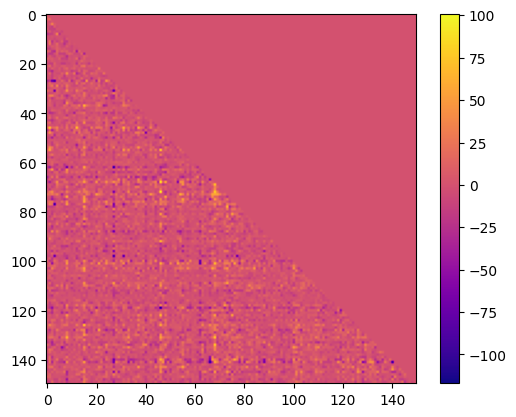

In [17]:
import matplotlib.pyplot as plt

# Conversion du dataframe en un tableau numpy
array = syn_df.values
# Extraction du triangle inférieur et remplacement de la partie supérieure par des NaN
array = np.tril(array)

fig, ax = plt.subplots()
im = ax.imshow(array, cmap='plasma')
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

## 5.2 Création d'un nouveau jeu de données enrichi

On souhaite maintenant enrichir notre jeu de données avec 2 nouvelles colonnes : la valeur de la synergie de l'équipe 1 et de l'équipe 2 (Syn1, Syn2).

On calcule donc les synergies des 2 équipes sur l'ensemble des matchs de notre jeu de données.

In [18]:
# On calcul maintenant la synergie de chaque équipe du jeu de données et on sauvegarde ce score dans le jeu de données.
# On défini nos listes de valeurs de synergie de chaque équipe pour chaque match.
syn1 = [0 for i in range(len(X))]
syn2 = [0 for i in range(len(X))]

for k in range(len(X)):
    x = X[k]
    # On créer la liste des index des champions des 2 équipes sur le match. 
    index_team1 = []
    index_team2 = []
    for i in range(150):
        if(x[i] == 1):
            index_team1.append(i)
        if(x[i+150] == 1):
            index_team2.append(i)

    # On parcourt chaque paire de champion de l'équipe 1.
    for i in index_team1:
        for j in index_team1:
            if j != i:
                syn1[k] += synergy_matrix[i][j]
    
    # On fait la même chose pour l'équipe 2.
    for i in index_team2:
        for j in index_team2:
            if j != i:
                syn2[k] += synergy_matrix[i][j]

Une fois nos colonnes créées sous forme de liste, on les ajoute à notre dataframe du jeu de données intial et on le sauvegarde dans un csv : *final_dataset_with_synergy.csv*.

In [19]:
# On ajoute les colonnes au dataset initial
new_dataset = dataset.assign(Syn1=syn1, Syn2=syn2)
new_dataset.to_csv('final_dataset_with_synergy.csv', index=False)
new_dataset.shape

(34678, 303)

## 5.3 Entraînement sur le nouveau jeu de données

Pour effectuer ce nouvel entraînement, on utilise le nouveau jeu de données *new_dataset*.

Cet entraînement différera du premier seulement sur la définition de l'entrée qui aura maintenant 302 valeurs (151 par équipe).

In [20]:
new_input_dataframe = new_dataset.drop(columns="Team1")  # On récupère toutes les colonnes sauf la colonne des victoires
new_output_dataframe = new_dataset[["Team1"]]            # On récupère seulement la colonne des victoires

new_X = new_input_dataframe.to_numpy()
new_Y = new_output_dataframe.to_numpy().ravel() 

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_Y, test_size=0.33) # On divise notre jeu de données
print(new_X_train.shape)
print(new_X_test.shape)

(23234, 302)
(11444, 302)


### 5.3.1 Modèle Decision Tree (DT)

In [21]:
new_dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=150, max_features=300)
new_dt_clf = new_dt_clf.fit(new_X_train, new_y_train)

new_dt_accuracy = new_dt_clf.score(new_X_test, new_y_test)
print("[Decision Tree] Score d'accuracy : ", new_dt_accuracy) 

[Decision Tree] Score d'accuracy :  0.8462950017476407


### 5.3.2 Modèle Random Forest (RF)

In [22]:
new_rf_clf = RandomForestClassifier(n_estimators=100)
new_rf_clf = new_rf_clf.fit(new_X_train, new_y_train)

new_rf_accuracy = new_rf_clf.score(new_X_test, new_y_test)
print("[Random Forest] Score d'accuracy : ", new_rf_accuracy) 

[Random Forest] Score d'accuracy :  0.8725096120237679


### 5.3.3 Modèle Artificial Neural Network (ANN)

In [23]:
new_model = models.Sequential()
new_model.add(layers.Dense(128, activation='relu', input_shape=(302,)))
new_model.add(layers.Dense(64, activation='relu'))
new_model.add(layers.Dropout(0.2))
new_model.add(layers.Dense(32, activation='relu'))
new_model.add(layers.Dense(1, activation='sigmoid'))

new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
new_model.fit(new_X_train, new_y_train, epochs=7, batch_size=32)

Epoch 1/7
727/727 [==============================] - 2s 2ms/step - loss: 0.6969 - accuracy: 0.6502
Epoch 2/7
727/727 [==============================] - 1s 2ms/step - loss: 0.6153 - accuracy: 0.6623
Epoch 3/7
727/727 [==============================] - 1s 2ms/step - loss: 0.6112 - accuracy: 0.6677
Epoch 4/7
727/727 [==============================] - 1s 2ms/step - loss: 0.6100 - accuracy: 0.6701
Epoch 5/7
727/727 [==============================] - 1s 2ms/step - loss: 0.6053 - accuracy: 0.6728
Epoch 6/7
727/727 [==============================] - 2s 2ms/step - loss: 0.6048 - accuracy: 0.6683
Epoch 7/7
727/727 [==============================] - 1s 2ms/step - loss: 0.5985 - accuracy: 0.6777


Sauvegarde et chargement pour éviter de réentraîner le modèle.

In [25]:
new_model.save('new_model.h5')

In [26]:
new_model = load_model('new_model.h5')

Calcul du score d'accuracy.

In [27]:
new_cnn_accuracy = new_model.evaluate(new_X_test, new_y_test, verbose=0)
print("[ANN] Score d'accuracy [loss, accuracy] :", new_cnn_accuracy)

[ANN] Score d'accuracy [loss, accuracy] : [0.6019881367683411, 0.6807060241699219]


## 5.4 Evaluation des nouvelles performances

De la même manière que précédemment, nous calculons la métrique de l'accuracy pour évaluer nos performances.

In [28]:
# Procédure K-Fold pour les modèles Decision Tree et Random Forest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mean_score_dt = np.mean(cross_val_score(new_dt_clf, new_X, new_Y, cv=k_fold))
mean_score_rf = np.mean(cross_val_score(new_rf_clf, new_X, new_Y, cv=k_fold))

print("[DT] Scores CV :", mean_score_dt)
print("[RF] Scores CV :", mean_score_rf)

[DT] Scores CV : 0.8815964895649087
[RF] Scores CV : 0.8981773662007321


In [29]:
# Procédure K-Fold pour le modèle de réseau de neurones artificiels
validation_scores = []

for train_index, val_index in k_fold.split(X):
    X_train_kfold, X_val_kfold = new_X[train_index], new_X[val_index]
    y_train_kfold, y_val_kfold = new_Y[train_index], new_Y[val_index]
    
    model_kfold = models.Sequential()
    model_kfold.add(layers.Dense(128, activation='relu', input_shape=(302,)))
    model_kfold.add(layers.Dense(64, activation='relu'))
    model_kfold.add(layers.Dropout(0.2))
    model_kfold.add(layers.Dense(32, activation='relu'))
    model_kfold.add(layers.Dense(1, activation='sigmoid'))
    model_kfold.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    fitted_model = model_kfold.fit(X_train_kfold, y_train_kfold, epochs=7, batch_size=32, validation_data=(X_val_kfold, y_val_kfold))
    
    validation_score = np.mean(fitted_model.history['val_accuracy'])
    validation_scores.append(validation_score)
    
mean_score_ann = np.mean(validation_scores)
print("[ANN] Scores CV :", mean_score_ann)

Epoch 1/7
867/867 [==============================] - 2s 2ms/step - loss: 0.6821 - accuracy: 0.6475 - val_loss: 0.6085 - val_accuracy: 0.6742
Epoch 2/7
867/867 [==============================] - 2s 2ms/step - loss: 0.6159 - accuracy: 0.6643 - val_loss: 0.6085 - val_accuracy: 0.6759
Epoch 3/7
867/867 [==============================] - 2s 2ms/step - loss: 0.6103 - accuracy: 0.6668 - val_loss: 0.6145 - val_accuracy: 0.6714
Epoch 4/7
867/867 [==============================] - 2s 2ms/step - loss: 0.6090 - accuracy: 0.6661 - val_loss: 0.6051 - val_accuracy: 0.6684
Epoch 5/7
867/867 [==============================] - 2s 2ms/step - loss: 0.6054 - accuracy: 0.6665 - val_loss: 0.6028 - val_accuracy: 0.6757
Epoch 6/7
867/867 [==============================] - 2s 2ms/step - loss: 0.6011 - accuracy: 0.6663 - val_loss: 0.5995 - val_accuracy: 0.6850
Epoch 7/7
867/867 [==============================] - 2s 2ms/step - loss: 0.5907 - accuracy: 0.6736 - val_loss: 0.5899 - val_accuracy: 0.6881
Epoch 1/7
867

Tableau de comparaison des scores des nouveaux modèles : 

Modèle  | Anciens score d'accuracy CV | Nouveaux score d'accuarcy CV
--------|:------------------------:|:------------------------:
Decision Tree (DT)   | 86.9 %      | 88.0 %
Random Forest (RF)   | 87.1 %      | 89.9 %
Artificial Neural Network (ANN) | 76.3 % | 67.1 %

## 5.5 Prédiction avec notre modèle

Lorsqu'on souhaitera faire une prédiction avec le nouveau modèle, il nous faudra calculer les synergies des équipes données en entrée.
<br><br>
Ainsi, on crée une fonction *get_synergy()* qui en donnant une liste de 150 valeurs en entrée (correspondant à la composition d'une équipe), renvoie la valeur de la synergie de cette équipe. <br>
Cette valeur est simplement la somme des synergies de chaque paire de l'équipe (sans compter 2 fois les symétries).

In [30]:
def get_synergy(team):
    """
    Retourne la valeur de synergie de l'équipe. Prend une liste de 150 valeurs entre 0 et 1 en entrée. 
    """
    df = pd.read_csv('synergy_matrix.csv')
    synergy_matrix = df.values
    
    synergy = 0
    # On créer la liste des index des champions des 2 équipes sur le match. 
    index_team = []
    for i in range(150):
        if(team[i] == 1):
            index_team.append(i)

    # On parcourt chaque paire de champion de l'équipe 1.
    for i in index_team:
        for j in index_team:
            if j != i:
                synergy += synergy_matrix[i][j]
    return synergy

Pour simplifier la prédiction, on crée une fonction qui prend deux listes d'équipe en entrée et qui renvoie la probabilité de victoire de l'équipe 1.

On crée seulement la fonction pour le modèle Random Forest, mais on pourrait créer les autres fonctions sur le même principe.


In [33]:
def predict_proba_rf(team1, team2):
    name_list = dataset.columns.tolist()
    index_t1 = []
    index_t2 = []

    # Conversion des String de champion en valeur 1
    for val in team1:
        index_t1.append(name_list.index(val))
    for val in team2:
        index_t2.append(name_list.index(val))
    Xt = [0 for x in range(300)]
    for val in index_t1:
        Xt[val] = 1
    for val in index_t2:
        Xt[val + 150] = 1
    
    # Ajout des syngeries
    Xt.append(get_synergy(Xt[:150]))
    Xt.append(get_synergy(Xt[150:300]))

    return new_rf_clf.predict_proba([Xt])[0][1] # predict_proba() renvoie un élément de la forme [[1-p, p]] avec p la probabilité de victoire de l'équipe 1

# **6. RESULTATS OBTENUS ET DISCUSSIONS**

## 6.1 Analyse des résultats 

Tableau de comparaison des scores des modèles : 

Modèle  | Anciens score d'accuracy CV | Nouveaux score d'accuarcy CV
--------|:------------------------:|:------------------------:
Decision Tree (DT)   | 86.9 %      | 88.0 %
Random Forest (RF)   | 87.1 %      | 89.9 %
Artificial Neural Network (ANN) | 76.3 % | 67.1 %

Avec le peu de données que nous avions (34000) comparé a l'ensemble des possibilités de composition d'équipe, nous avons obtenu des scores de performances plutôt élevés. <br>

Nous pensons que puisque le jeu de données comprennait des données de matchs réels, une multitude de composition d'équipes n'ont jamais été proposé puisqu'elles n'auraient pas forcément de sens au vu du jeu (par exemple une équipe de 5 champions spécialisés dans le soutient). De ce fait, le modèle obtient un score plutôt élevé de prédiction de victoire lorsque les équipes ne sont pas générées aléatoirement.

On remarque que lors de notre premier entraînement, les trois modèles ont des performances similaires. Puis, avec l'introduction de la synergie dans les données, les modèles de Decision Tree et de Random Forest sont devenus plus performants.<br>

Cependant, le score du réseau de neurones artificiels a chuté. Nous avons essayé de normaliser les données de synergie, mais cela n'a rien changé sur les performances du modèle ANN. Nous pensons qu'une adaptation des couches de notre réseau de neurones serait la clef pour obtenir de meilleurs résultats.

## 6.2 Limites du modèle

Nous pourrions aller plus loin dans la recherche de paramètres permettant d'améliorer la description de matchs (comme le win rate de chaque champion, etc.), mais aussi dans la recherche de meilleurs hyper-paramètres. <br>

Et comme décrit précédemment, il faudrait revoir les couches du réseau de neurones artificiels pour améliorer ses performances.

# **7. SOLUTION FINALE**

Au vu des scores d'accuracy obtenus, il nous semble plus intéressant d'utiliser le modèle de Random Forest. Ayant quasiement le même score que celui du Decision Tree, ce choix est assez arbitraire.
Notre solution finale est donc le RandomForestClassifier précédent : *new_clf_rf*.

Avec la fonction *predict_proba_rf(team1, team2)* de la partie 5.5 qui calcule aussi la synergie des équipes d'entrée, on peut prédire simplement la probabilité de victoire de l'équipe 1, comme sur l'exemple suivant :

In [34]:
# Définition de nos deux équipes
team1 = ["Shen", "Warwick", "Zed", "Caitlyn", "Zyra"]
team2 = ["Garen", "Jarvan IV", "Aurelion Sol", "Miss Fortune", "Lux"]

prediction = predict_proba_rf(team1, team2)

print(f"Probabilité de victoire de l'équipe 1 : {prediction}")

Probabilité de victoire de l'équipe 1 : 0.69


# **8. ANNEXES**



## 1. Introduction

## **Arbres de décision**


L'arbre de décision est un algorithme couramment utilisé en apprentissage automatique pour représenter de manière claire et précise les décisions et la prise de décision dans les problèmes de classification et de régression. Il est utilisé pour modéliser des processus décisionnels complexes en décomposant le problème en décisions binaires successives.

Cela peut être représenté sous la forme d'une structure descendante constituée de nœuds. Chaque nœud contient une condition qui mène à plusieurs réponses et guide la progression vers le nœud suivant.

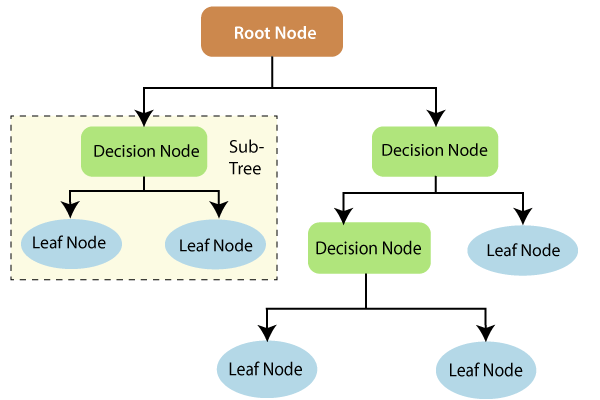

Il se compose de trois composants : les nœuds de décision, les feuilles et un nœud racine. Un algorithme d'arbre de décision divise un ensemble de données d'entraînement en branches, qui se divisent ensuite en d'autres branches. Cette séquence se poursuit jusqu'à ce qu'une feuille (ou noeud terminal) soit atteinte. La feuille ne peut pas être divisé davantage.

Un arbre de décision est donc une structure de données qui aide à prendre des décisions en divisant un ensemble de données en sous-ensembles plus petits jusqu'à ce qu'il atteigne un point où il ne peut plus être divisé. Les nœuds de décision représentent des tests à effectuer sur les données, les branches représentent les résultats possibles de ces tests, et les feuilles représentent les décisions finales basées sur les résultats des tests.

Pour savoir où diviser les données dans un arbre de décision, on utilise une mesure de sélection d'attribut. C'est une méthode heuristique pour sélectionner le critère de division le plus efficace pour obtenir des classes individuelles. Les mesures de sélection d'attribut sont également appelées règles de division et elles définissent comment les données doivent être divisées à un certain niveau dans l'arbre de décision. 

Voici quelques mesures de sélection d'attribut 

- **Gain d'information** : mesure la quantité d'informations que l'on gagne en utilisant un attribut particulier pour diviser les données.L'entropie est une mesure de l'incertitude ou du degré d'imprévisibilité d'un ensemble de données. Lorsqu'on divise les données en utilisant un attribut, le gain d'information mesure la réduction de l'entropie entre les données avant et après la division.
En choisissant l'attribut avec le gain d'information le plus élevé, on peut construire un arbre de décision qui permet de classer les données avec la plus grande précision possible. Cependant, cette mesure a une tendance à favoriser les attributs qui ont un grand nombre de valeurs, ce qui peut entraîner une perte de précision dans la classification des données

- **Rapport de Gain**: une amélioration de la mesure de gain d'information qui prend en compte le nombre de valeurs possibles d'un attribut lors de la sélection de l'attribut de division dans un arbre de décision

- **Indice de Gini**: mesure l'impureté d'un ensemble de données en considérant la distribution des classes dans cet ensemble.Il mesure la probabilité qu'un élément tiré au hasard de l'ensemble soit mal classé en choisissant une classe au hasard selon la distribution de classes dans l'ensemble. Il est calculé de la façon suivante:



> $Gini(D) = 1 - \sum_{i=1}^c (p(i))^2$

où D est l'ensemble de données, c est le nombre de classes, et p(i) est la probabilité de la classe i dans l'ensemble de données.


Donnons un exemple concret: supposons que nous voulions prédire si un client achètera ou non un téléphone portable. Les caractéristiques du téléphone constituent la base de sa décision.Le nœud racine et les nœuds de décision de l'arbre de décision représentent les caractéristiques du téléphone mentionnées ci-dessus. Le nœud feuille représente la sortie finale, soit l'achat, soit la non-achat. Les principales caractéristiques qui déterminent le choix comprennent le prix, le stockage interne et la mémoire vive (RAM). L'arbre de décision aura l'apparence suivante:

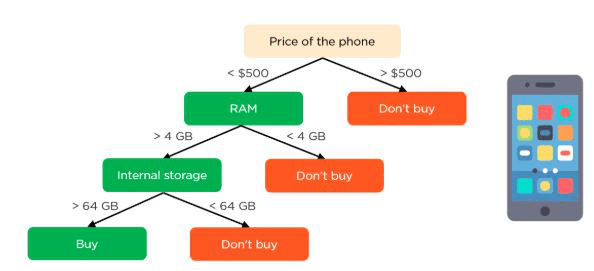


## **Random Forest**

L'algorithme Random Forest est une méthode d'apprentissage automatique qui combine plusieurs arbres de décision pour obtenir une prédiction plus précise et stable. La feuille de chaque arbre est la sortie finale produite par cet arbre de décision spécifique. La sélection de la sortie finale suit le système de vote majoritaire. Dans ce cas, la sortie choisie par la majorité des arbres de décision devient la sortie finale du système de forêt aléatoire. Le diagramme ci-dessous montre un classificateur de forêt aléatoire simple: 

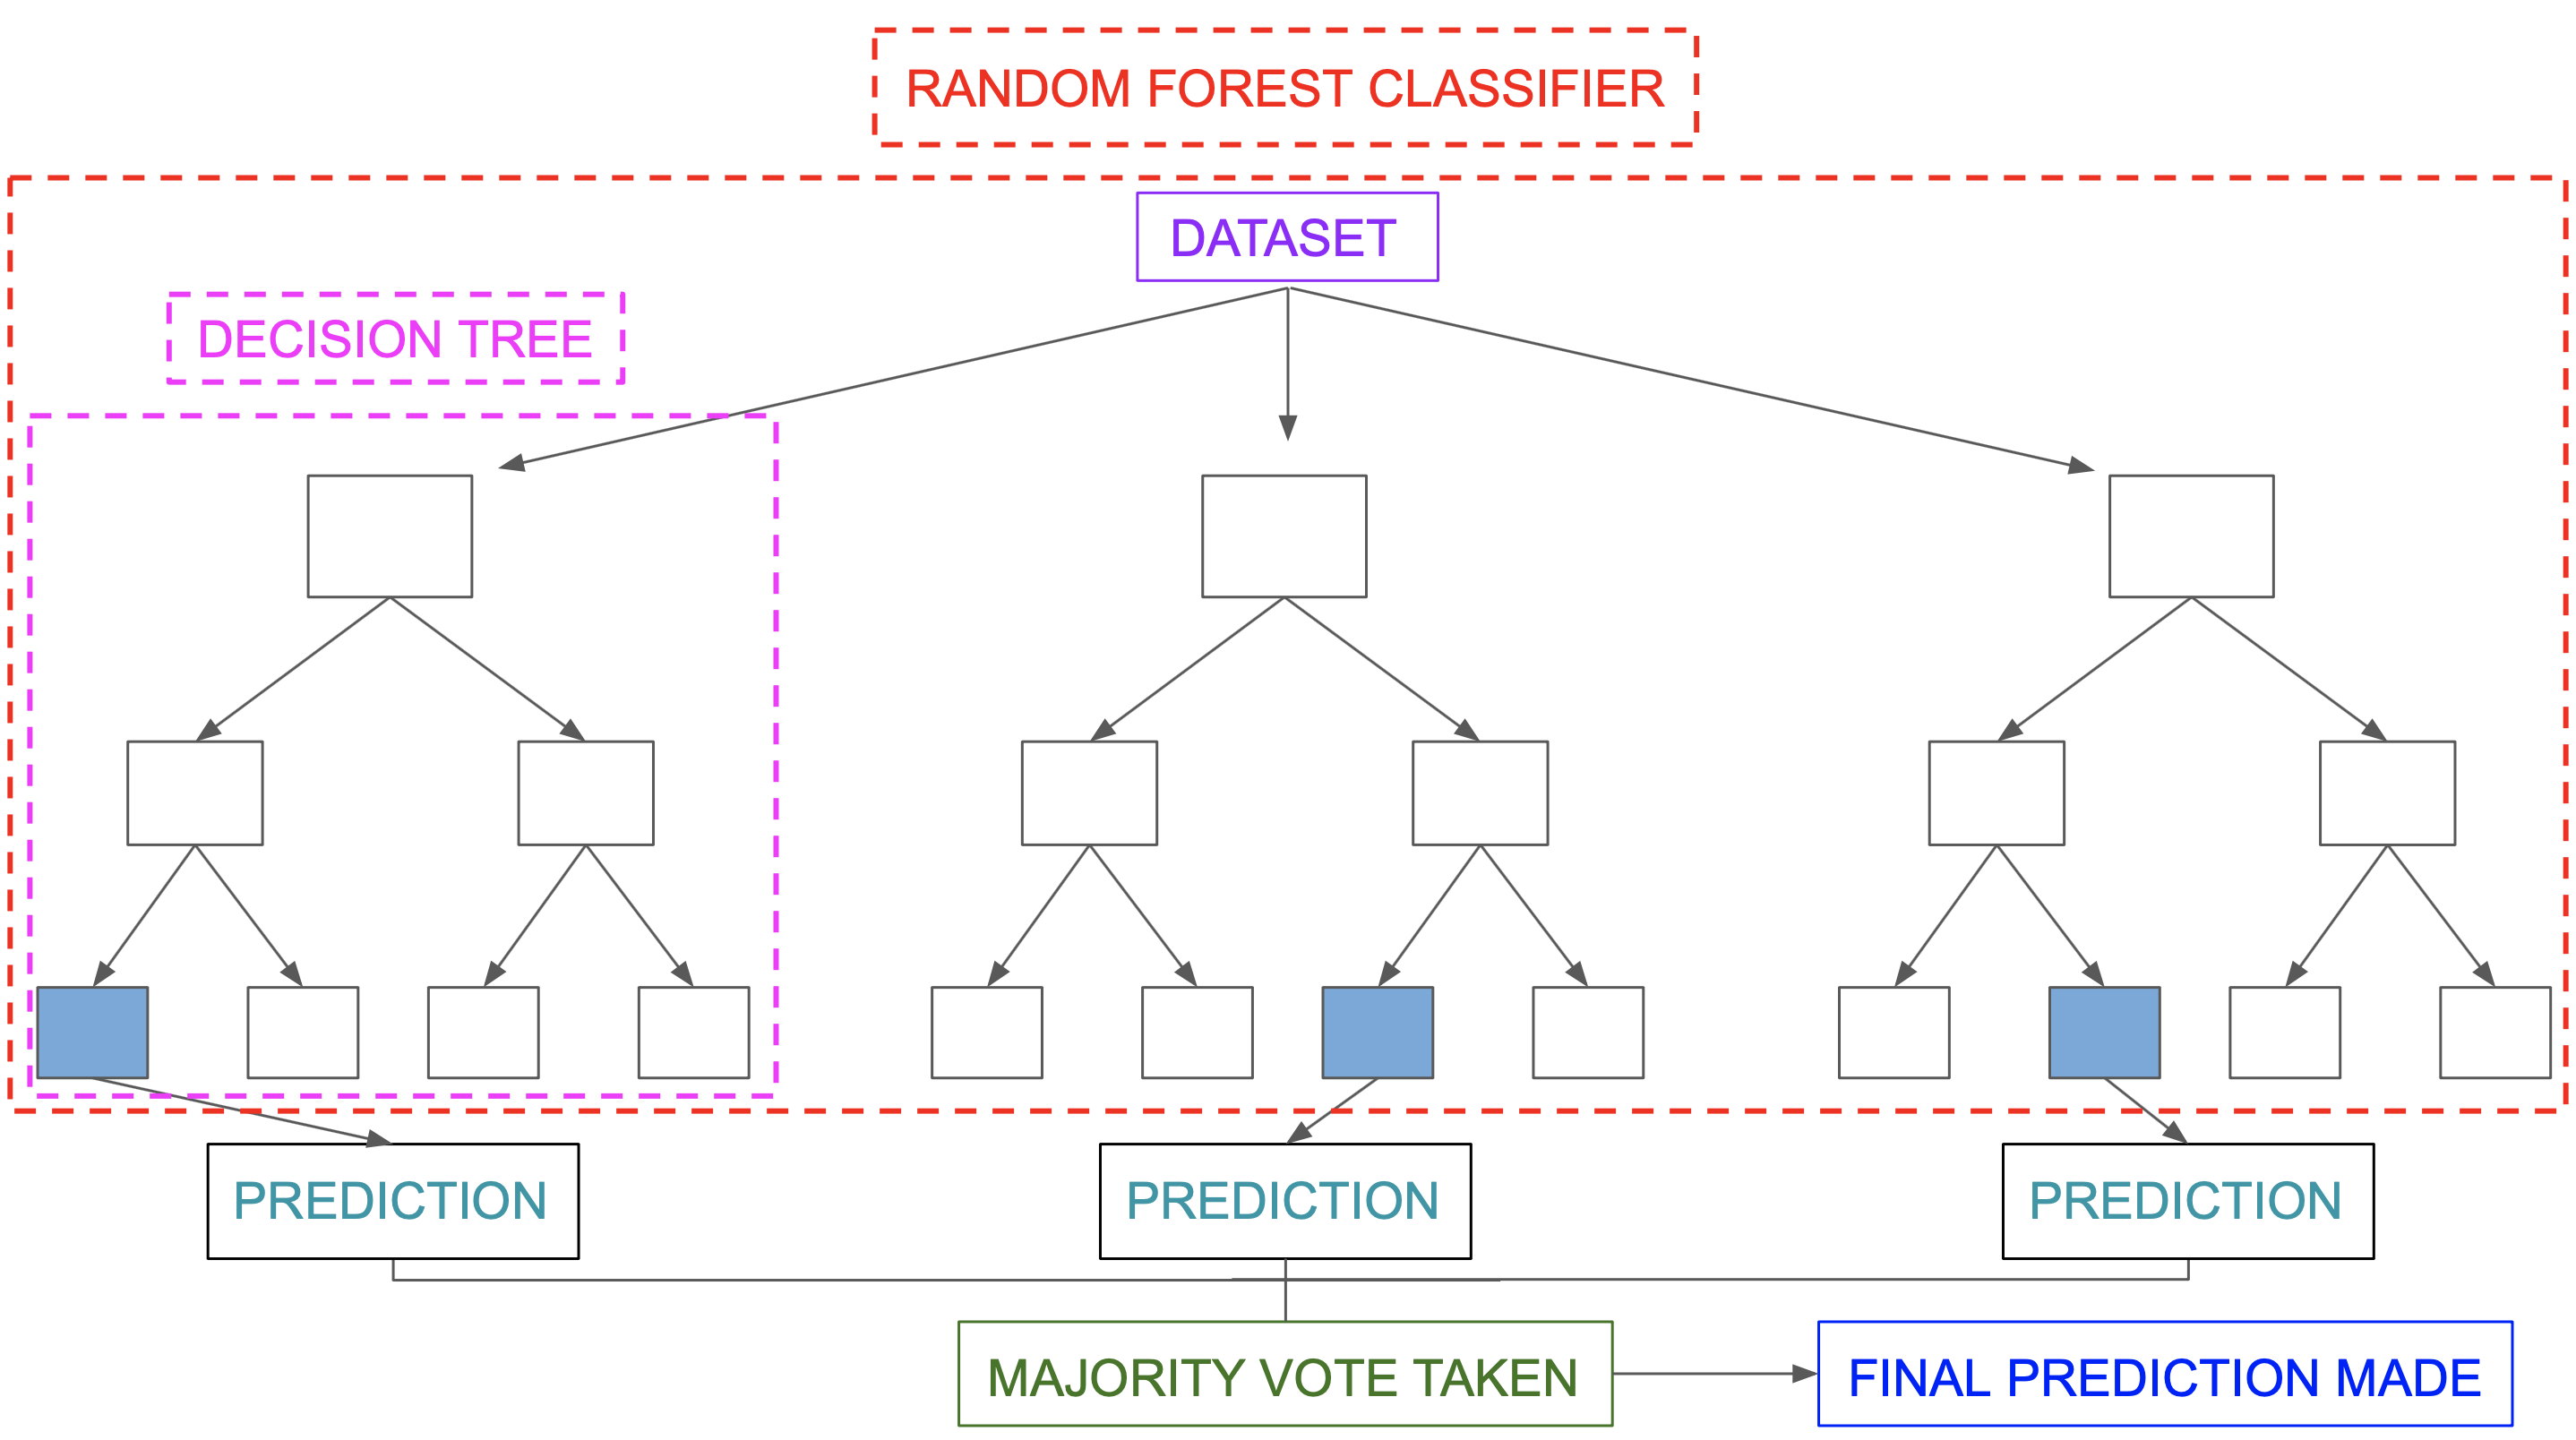

Cependant, chaque méthode possède ses avantages et ses inconvénients :

### Arbres de décision

<table style="width:100%">
 <tr>
    <th style="text-align:center">Avantages</th>
    <th style="text-align:center">Inconvénients</th>
 </tr>
 <tr>
    <td>
      *   Facilité d'interprétation et de visualisation <br>
      *   Peu traiter des données avec des valeurs manquantes <br>
      *   Peu de prétraitement des données nécessaire  
    </td>
    <td>
      *   Sensible au surapprentissage <br>
      *   Peut être instable face aux petites variations des données  
    </td>
 </tr>
</table>

### Random Forests

<table style="width:100%">
 <tr>
    <th style="text-align:center">Avantages</th>
    <th style="text-align:center">Inconvénients</th>
 </tr>
 <tr>
    <td>
      *   Facilité d'interprétation et de visualisation <br>
      *   Peu traiter beaucoup de features <br>
      *   Réduit le risque d'overfitting en combinant différents arbres 
    </td>
    <td>
      *   Long à entraîner <br>
      *   Moins facile d'interprétation <br>
      *   Plus sensible aux valeurs manquantes et aux erreurs
    </td>
 </tr>
</table>

Réferences : https://heartbeat.comet.ml/understanding-the-mathematics-behind-decision-trees-22d86d55906

https://www.section.io/engineering-education/introduction-to-random-forest-in-machine-learning/

https://www.ibm.com/fr-fr/topics/decision-trees


# 2. Code


Dans cette partie du rapport, nous allons étudier la manière dont nous avons utilisé les arbres de décision et les forêts aléatoires pour prédire les résultats des matchs de League of Legends à partir de notre base de données. Notre objectif est d'évaluer la pertinence de ces méthodes pour notre projet et d'en discuter les résultats.

### Importation des bibliothèques nécessaires

Dans cette partie du code, nous importons les bibliothèques et les modules nécessaires pour notre projet de machine learning.

- pandas : Bibliothèque est utilisée pour manipuler et analyser les données sous forme de DataFrames.

- RandomForestClassifier : Classe nous permet de créer et d'entraîner un modèle de forêt aléatoire.

- DecisionTreeClassifier : Classe nous permet de créer et d'entraîner un modèle d'arbre de décision.

- train_test_split : Fonction nous permet de diviser notre ensemble de données en ensembles d'apprentissage et de test.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### Chargement et préparation des données

Le fichier 'Lol_matchs.csv' est lu et stocké dans un DataFrame dans lequel on retire la colonne de victoire de l'équipe 2 (car elle est déductible à partir de la victoire ou non victoire de l'équipe 1).
Ensuite, nous avons créé un nouveau DataFrame input_dataframe en supprimant la colonne "Team1_victory" qui contient le résultat des matchs de notre DataFrame initial.
Nous extrayons les sorties en créant un autre DataFrame output_dataframe en sélectionnant uniquement la colonne "Team1_victory".

Nous convertissons les DataFrames input_dataframe et output_dataframe en tableaux NumPy (respectivement X et Y) pour faciliter leur utilisation dans les modèles d'apprentissage automatique. La fonction ravel() sert à transformer Y en un tableau unidimensionnel.

In [ ]:
dataset = pd.read_csv('Lol_matchs.csv')
dataset = dataset.drop(columns="Team2")

input_dataframe = dataset.drop(columns="Team1")  # On récupère toutes les colonnes sauf la colonne des victoires
output_dataframe = dataset[["Team1"]]            # On récupère seulement la colonne des victoires

# On converti les dataframe en numpy array
X = input_dataframe.to_numpy()
Y = output_dataframe.to_numpy().ravel() 

### Entraînement et évaluation du modèle

Nous utilisons la fonction train_test_split pour diviser les données en ensembles d'apprentissage et de test avec une répartition de 67% pour l'apprentissage et 33% pour le test.

Après ça, nous créons un objet de Classifier avec ses hyper-paramètres.

Ici, nous créons un objet RandomForestClassifier avec 100 estimateurs (qui représentent chacun un arbre de décision) et un objet DecisionTreeClassifier avec une profondeur de 10 (pour 10 champions choisis au maximum), et un maximum de paramètres différents de 150 (pour 150 champions possibles dans la base de données).
  


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

clf_rf = RandomForestClassifier(n_estimators=100)
clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=150)

Nous pouvons ensuite entraîner les modèles avec les ensembles d'apprentissage X_train et y_train.
Une fois les modèles entraînés, nous pouvons utiliser les fonctions *predict* et *predict_proba* pour prédire la victoire ou pas de l'équipe 1 en fonction des équipes.

In [ ]:
clf_rf = clf_rf.fit(X_train, y_train)
clf_dt = clf_dt.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)
y_pred_proba_dt = clf_dt.predict_proba(X_test)

### Calcul des scores de performance des modèles

Ici, nous nous intéressons à la métrique de l'accuracy car nous nous intéressons seulement à la justesse/exactitude du modèle. Pour rappel, l'accuracy en classification binaire vaut : 
- $Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$
- Avec VP = Vrais positifs, VN = Vrais négatifs, FP = Faux positifs et FN = Faux négatifs

Ce score nous permet d'évaluer la performance de notre modèle.
<br><br>
Bien entendu, il existe d'autres métriques qui permettent de calculer les performances des modèles de d'autres façons, pour des cas d'utilisations différents.

In [ ]:
score_rf = clf_rf.score(X_test, Y_test)
score_dt = clf_dt.score(X_test, Y_test)

print("[RF] Score d'accuracy : ", score_rf)
print("[DT] Score d'accuracy : ", score_dt)